# ECON323 Final Project
***Predict the next day rain based on current day in Australia***

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import geopandas as gpd
import folium
from shapely.geometry import Point
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import (LabelEncoder, StandardScaler)
from sklearn import (
    linear_model, metrics, neural_network, pipeline, preprocessing, model_selection)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import (GridSearchCV, cross_val_score)
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

In [87]:
# Import data
weatherAus_raw=pd.read_csv('~/Desktop/Final Project/weatherAUS.csv')
df=weatherAus_raw

## Exploratory Data Analysis

### Exploration

In [88]:
df.shape

(145460, 23)

There are 145460 instances and 23 variables.

In [89]:
weatherAus_raw.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


By a glimpse of the several first rows in the dataset, it can be observed that variables includeing, `Evaporation`, `Sunshine`, `Cloud9am` and `Cloud3pm` have missing values.

In [90]:
# Percentage of missing values in each column
df.isnull().sum()/df.shape[0]

Date             0.000000
Location         0.000000
MinTemp          0.010209
MaxTemp          0.008669
Rainfall         0.022419
Evaporation      0.431665
Sunshine         0.480098
WindGustDir      0.070989
WindGustSpeed    0.070555
WindDir9am       0.072639
WindDir3pm       0.029066
WindSpeed9am     0.012148
WindSpeed3pm     0.021050
Humidity9am      0.018246
Humidity3pm      0.030984
Pressure9am      0.103568
Pressure3pm      0.103314
Cloud9am         0.384216
Cloud3pm         0.408071
Temp9am          0.012148
Temp3pm          0.024811
RainToday        0.022419
RainTomorrow     0.022460
dtype: float64

The table above shows there are missing values in all variables, except for `Date` and `Location`. In some variables, like `Evaporation`, `Sunshine`, `Cloud9am` and `Cloud3pm`, the proportion of missing values is even greater than 35%, which means a large proportion of samples are missing. The missing value problem will be addressed in the next part.

In [91]:
# data type of each variable
df.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

`Date`, `Location`, `WindGustDir`,`WindDir9am`,`WindDir3pm`,`RainToday` and `RainTomorrow` are categorical, the remaining are numerical.

In [92]:
# the code is adapted from previous project: 'Classification Analysis of Suicide Rates'
# unique values of categorical variables
cate_cols=['Location','WindGustDir','WindDir9am','WindDir3pm','RainToday','RainTomorrow']

for col in list(cate_cols):
    print(f"\033[1m {col} unique values: \033[0m")
    print("")
    print(df[col].unique())
    print("")
    print(f"\033[1m Number of unique values: \033[0m")
    print(len(df[col].unique()))

 Location unique values: 

['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru']

 Number of unique values: 
49
 WindGustDir unique values: 

['W' 'WNW' 'WSW' 'NE' 'NNW' 'N' 'NNE' 'SW' nan 'ENE' 'SSE' 'S' 'NW' 'SE'
 'ESE' 'E' 'SSW']

 Number of unique values: 
17
 WindDir9am unique values: 

['W' 'NNW' 'SE' 'ENE' 'SW' 'SSE' 'S' 'NE' nan 'SSW' 'N' 'WSW' 'ESE' 'E'
 'NW' 'WNW' 'NNE']

 Number of unique values: 
17
 WindDir3pm unique values: 

['WNW' 'WSW' 'E' 'NW' 'W' 'SS

There are records of rainfall conditions for 49 different locations in Australia. There are 16 different direction in wind direction related variables and nan means the value is missing. The records of whether rain today and whether rain tommorrow are binary with outcomes yes and no.

In [93]:
# summary statsitics of numerical variables
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


The section above has explored the data and it found that the main problem is missing value.

### Data Cleaning

#### Categorical variable

In [94]:
# select all numerical variables
cate_cols = df.select_dtypes([np.object]).columns
missing_cate_cols=cate_cols[2:-2]

In [95]:
missing_cate_cols

Index(['WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

In [96]:
for col in missing_cate_cols:
    df[col]=df[col].fillna(df[col].mode()[0])

The missing values in `WindGustDir`, `WindDir9am` and `WindDir3pm` are filled by the most frequent appear value. Since `RainToday` is perfectly correlated with `RainTommorrow` and we have a large number of samples, the missing value can be simply dropped when modelling.

#### Numerical variable

In [97]:
num_cols = df.select_dtypes([np.number]).columns

**Fill the missing numeric values using MICE Imputation** 

In [98]:
import warnings
warnings.filterwarnings("ignore") 
mice_imputer = IterativeImputer()
num_df=df[num_cols]
num_df.iloc[:,:]=mice_imputer.fit_transform(df[num_cols])

In [99]:
df[num_cols]=num_df

In [100]:
df.info()
df=df.dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        145460 non-null  float64
 3   MaxTemp        145460 non-null  float64
 4   Rainfall       145460 non-null  float64
 5   Evaporation    145460 non-null  float64
 6   Sunshine       145460 non-null  float64
 7   WindGustDir    145460 non-null  object 
 8   WindGustSpeed  145460 non-null  float64
 9   WindDir9am     145460 non-null  object 
 10  WindDir3pm     145460 non-null  object 
 11  WindSpeed9am   145460 non-null  float64
 12  WindSpeed3pm   145460 non-null  float64
 13  Humidity9am    145460 non-null  float64
 14  Humidity3pm    145460 non-null  float64
 15  Pressure9am    145460 non-null  float64
 16  Pressure3pm    145460 non-null  float64
 17  Cloud9am       145460 non-nul

 - All of the missing values requiring the processing has been filled.
 - We drop the rows that have missing value in `RainToday` and `RainTomorrow` since there are enough samples and in classification analysis, it is not required to fill the missing value in the target feature and `RainToday` is perfectly correlated with `RainTomorrow`, filling value in `RainToday` means filling value in the target feature `RainTomorrow`. 

### Univariate Data Analysis

#### Target Variable - RainTomorrow

<AxesSubplot:xlabel='RainTomorrow', ylabel='count'>

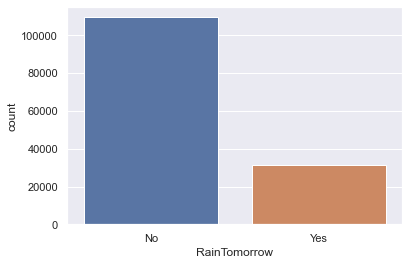

In [101]:
sns.countplot(x= df["RainTomorrow"])

In [102]:
df['RainTomorrow'].value_counts()/len(df)

No     0.778382
Yes    0.221618
Name: RainTomorrow, dtype: float64

The barplot and the figures above shows that there are approximately 77% of the sunny day and 23% of the rainny day.

#### Categorical variables

<AxesSubplot:xlabel='WindDir3pm', ylabel='count'>

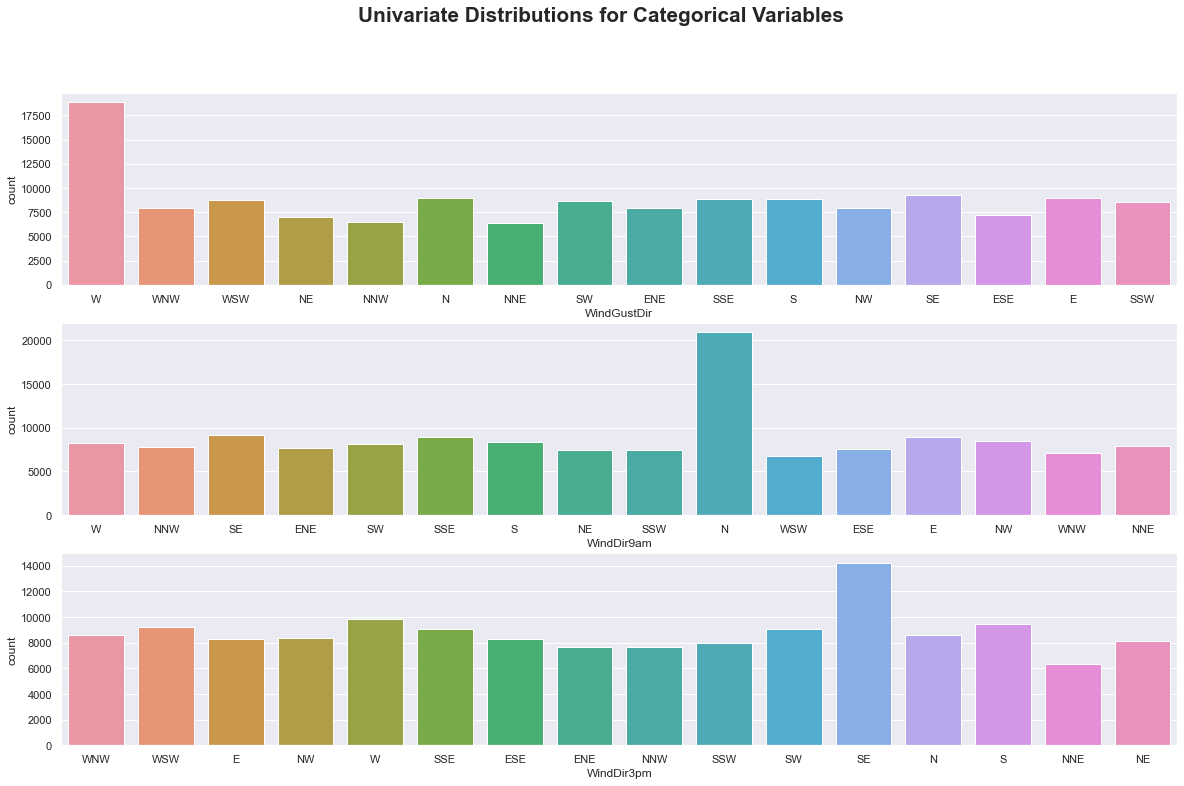

In [103]:
fig=plt.figure(figsize=(20,12),facecolor='white')

plt.suptitle('Univariate Distributions for Categorical Variables',weight='bold',fontsize='xx-large')

gs=fig.add_gridspec(3,1)

ax=[_ for i in range(3)]

ax[0]=fig.add_subplot(gs[0,0])
ax[1]=fig.add_subplot(gs[1,0])
ax[2]=fig.add_subplot(gs[2,0])


sns.countplot(x="WindGustDir",data=df,ax=ax[0])
sns.countplot(x="WindDir9am",data=df,ax=ax[1])
sns.countplot(x='WindDir3pm',data=df,ax=ax[2])

It can be seen that there are some wind direction which clearly appears the most compared to others. The speed (km/h) of the strongest wind gust in the 24 hours to midnight, i.e. `WindGustDir` is the most likely to be in the direction of **West**. At 9 pm, the wind is most likely to be from **North**. At 3pm, the wind direction is most likely to be from **Southeast**. It is likely that direction within some range is likely to have rain day due to meteorological reasons.

#### Continuous Variables

<AxesSubplot:xlabel='Sunshine'>

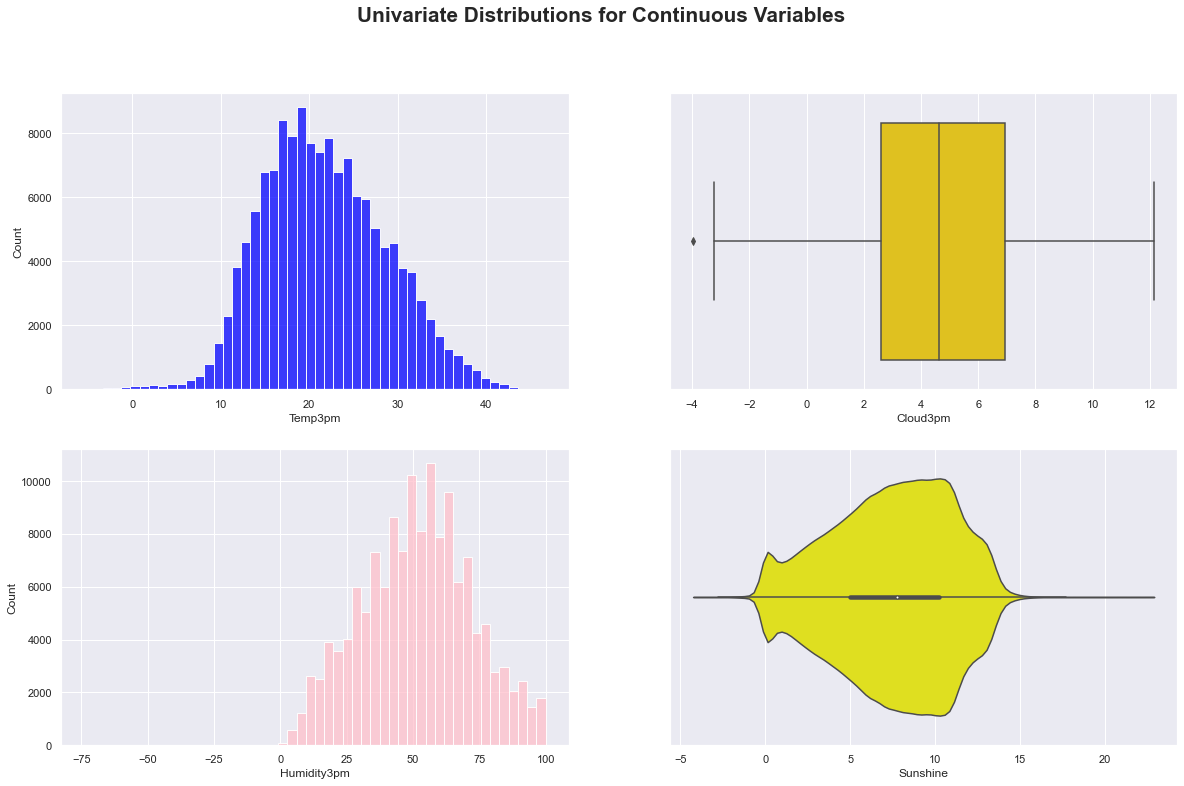

In [104]:
# this code is adpated from clean visualization rain in Australia
fig=plt.figure(figsize=(20,12),facecolor='white')

plt.suptitle('Univariate Distributions for Continuous Variables',weight='bold',fontsize='xx-large')

gs=fig.add_gridspec(2,2)

ax=[_ for i in range(4)]

ax[0]=fig.add_subplot(gs[0,0])
ax[1]=fig.add_subplot(gs[1,0])
ax[2]=fig.add_subplot(gs[0,1])
ax[3]=fig.add_subplot(gs[1,1])


sns.histplot(x="Temp3pm",data=df,ax=ax[0],bins=50,color='blue')
sns.histplot(x="Humidity3pm",data=df,ax=ax[1],bins=50,color='pink')
sns.boxplot(x='Cloud3pm',data=df,ax=ax[2],color='gold')
sns.violinplot(x="Sunshine",data=df,ax=ax[3],color='yellow')

The above shows the distribution for difference continuous variables. 

### Bivariate Data Analysis

**Location and Rainfall**

In [105]:
df['Location'].unique()

array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
       'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
       'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
       'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura',
       'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
       'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa',
       'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport',
       'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston',
       'AliceSprings', 'Darwin', 'Katherine', 'Uluru'], dtype=object)

In [106]:
NSW=['Albury','BadgerysCreek','Cobar','CoffsHarbour','Moree',
     'Newcastle','NorahHead','Penrith','Sydney','SydneyAirport',
    'WaggaWagga','Wollongong']
VIC=['Richmond','Williamtown','Ballarat','Bendigo','Sale', 'MelbourneAirport', 
     'Melbourne','Mildura','Nhil','Portland','Watsonia','Dartmoor']
ACT=['Canberra','Tuggeranong','MountGinini'
    ]
QLD=['Brisbane', 'Cairns',
       'GoldCoast','Townsville']
SA=[ 'Adelaide', 'MountGambier', 'Nuriootpa',
       'Woomera']
WA=['Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport',
       'Perth', 'SalmonGums', 'Walpole']
TAS=['Hobart', 'Launceston']
NT=['AliceSprings', 'Darwin', 'Katherine', 'Uluru']

In [107]:
state=[]
for i in df['Location']:
    if i in NSW:
        state.append('New South Wales')
    elif i in VIC:
        state.append('Victoria')
    elif i in ACT:
        state.append('Australian Capital Territory')
    elif i in QLD:
        state.append('Queensland')
    elif i in SA:
        state.append('South Australia')
    elif i in WA:
        state.append('Western Australia')
    elif i in TAS:
        state.append('Tasmania')
    elif i in NT:
        state.append('Northern Territory')
    else:
        state.append('None')

In [108]:
df['State']=state

In [109]:
map_df=df.groupby('State').mean()['Rainfall']
map_df=pd.DataFrame(map_df).reset_index()
map_df=map_df[map_df['State']!='None']
Latitude=[-35.473469,-31.840233,-19.491411,-20.917574,-30.000233,-41.640079,-37.020100,-25.042261]
Longitude=[149.012375,145.612793,132.550964,142.702789,136.209152,146.315918,144.964600,117.793221]
map_df['Latitude']=Latitude
map_df['Longitude']=Longitude
map_df["Coordinates"] = list(zip(map_df.Longitude, map_df.Latitude))
df=df.drop(['State'],axis=1)

In [110]:
map_df

,State,Rainfall,Latitude,Longitude,Coordinates
0,Australian Capital Territory,2.335164,-35.473469,149.012375,"(149.012375, -35.473469)"
1,New South Wales,2.693391,-31.840233,145.612793,"(145.612793, -31.840233)"
3,Northern Territory,2.676695,-19.491411,132.550964,"(132.550964, -19.491411)"
4,Queensland,4.021798,-20.917574,142.702789,"(142.702789, -20.917574)"
5,South Australia,1.385510,-30.000233,136.209152,"(136.209152, -30.000233)"
6,Tasmania,1.802886,-41.640079,146.315918,"(146.315918, -41.640079)"
7,Victoria,1.854834,-37.020100,144.964600,"(144.9646, -37.0201)"
8,Western Australia,2.048591,-25.042261,117.793221,"(117.793221, -25.042261)"


In [111]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/rowanhogan/australian-states/master/states.geojson') as response:
    state_geo = json.load(response)# Read the geojson data with Australia's state borders from github

In [112]:
# this code is adapted from github COVID-19 Australian data cleaning and exploratory analysis
map2 = folium.Map(location=[-25.8, 136.8698],tiles='cartodbpositron', zoom_start=5)
cases_proportion = map_df[['State','Rainfall']]
tiles = ['stamenwatercolor', 'cartodbpositron', 'openstreetmap', 'stamenterrain']

for tile in tiles:
    folium.TileLayer(tile).add_to(map2)
    
choropleth = folium.Choropleth(
    geo_data = state_geo,
    name = 'choropleth',
    data = cases_proportion,
    columns = ['State','Rainfall'],
    key_on = 'feature.properties.STATE_NAME',
    fill_color = 'YlGn',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = 'Average Rainfall Per Day in Each State (cm)',
    highlight = True
).add_to(map2)
map2

The interactive map above shows the average rainfall per day in each state. 

**Location and Sunshine**

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]),
 [Text(0, 0, 'Albury'),
  Text(1, 0, 'BadgerysCreek'),
  Text(2, 0, 'Cobar'),
  Text(3, 0, 'CoffsHarbour'),
  Text(4, 0, 'Moree'),
  Text(5, 0, 'Newcastle'),
  Text(6, 0, 'NorahHead'),
  Text(7, 0, 'NorfolkIsland'),
  Text(8, 0, 'Penrith'),
  Text(9, 0, 'Richmond'),
  Text(10, 0, 'Sydney'),
  Text(11, 0, 'SydneyAirport'),
  Text(12, 0, 'WaggaWagga'),
  Text(13, 0, 'Williamtown'),
  Text(14, 0, 'Wollongong'),
  Text(15, 0, 'Canberra'),
  Text(16, 0, 'Tuggeranong'),
  Text(17, 0, 'MountGinini'),
  Text(18, 0, 'Ballarat'),
  Text(19, 0, 'Bendigo'),
  Text(20, 0, 'Sale'),
  Text(21, 0, 'MelbourneAirport'),
  Text(22, 0, 'Melbourne'),
  Text(23, 0, 'Mildura'),
  Text(24, 0, 'Nhil'),
  Text(25, 0, 'Portland'),
  Text(26, 0, 'Watsonia'),
  Text(27, 0, 'Dartmoor'),
  Text(28,

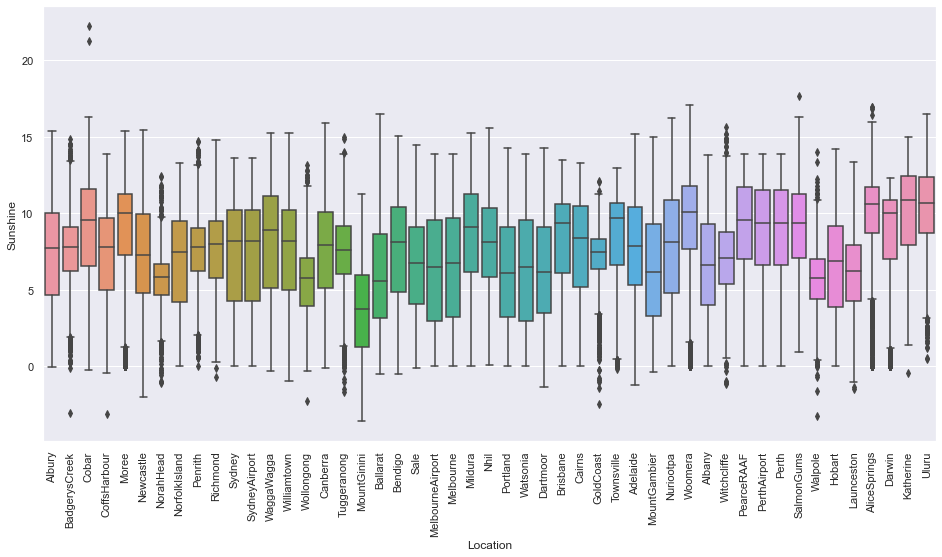

In [113]:
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x='Location', y="Sunshine", data=df)
fig.axis()
plt.xticks(rotation=90)

The above graph provides a visualization of distribution of sunshine in different locations. `MountGinini` has relatively low sunshine compared to other regions. `Uluru` and `Katherine` have relatively higher sunshine.

**RainTomorrow and Sunshine**

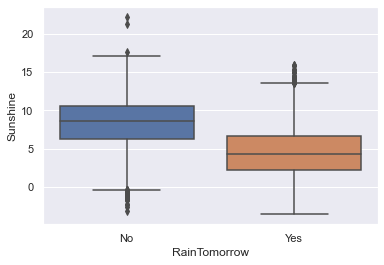

In [114]:
fig = sns.boxplot(x='RainTomorrow', y="Sunshine", data=df)

### Multivariate Data Analysis

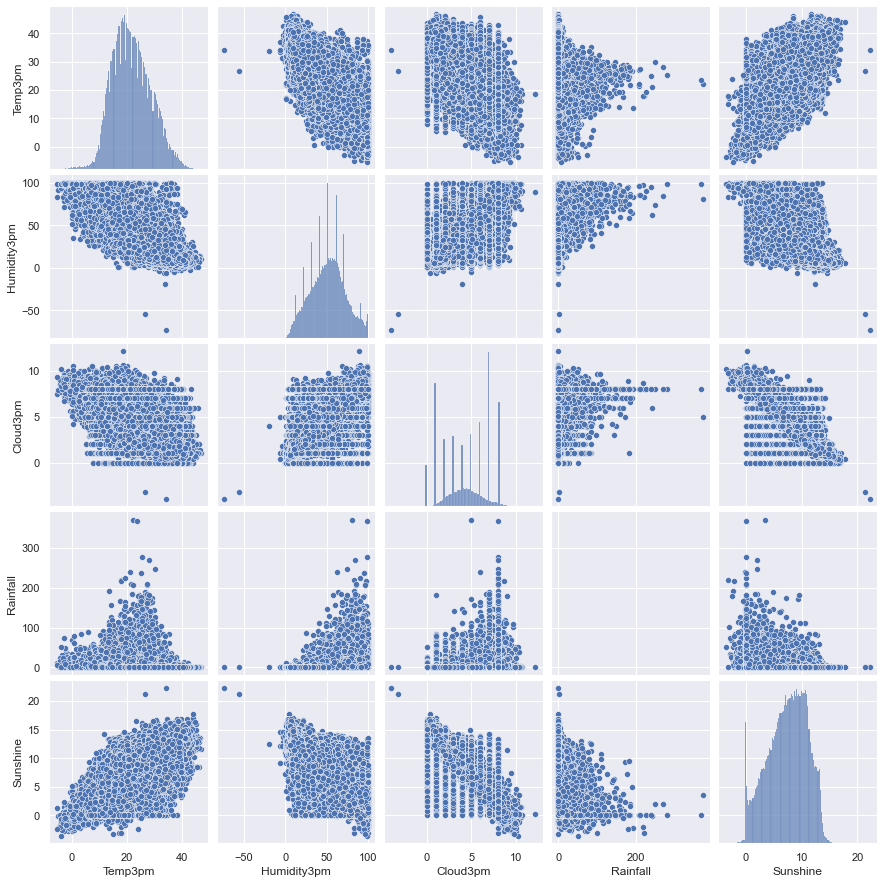

In [115]:
sns.set()
cols = ['Temp3pm', 'Humidity3pm', 'Cloud3pm', 'Rainfall', 'Sunshine']
sns.pairplot(df[cols], size = 2.5)
plt.show()

<AxesSubplot:>

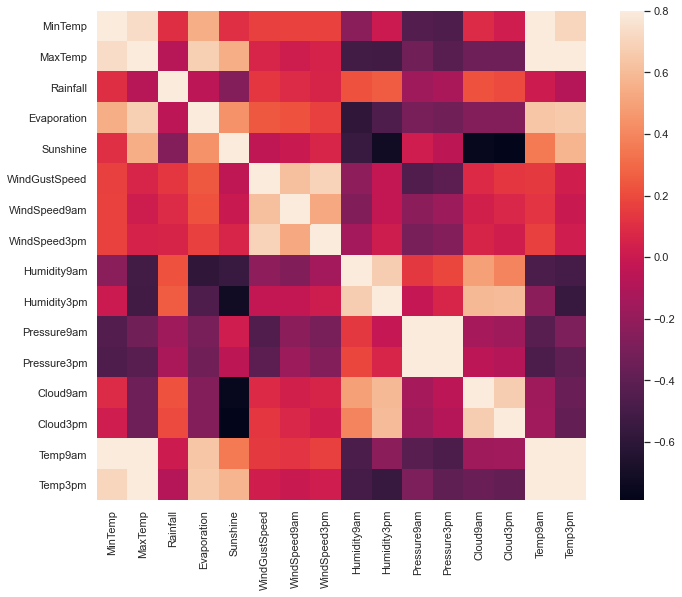

In [116]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

**Summary of key findings from heatmap and pair plot**

1. `Evaporation` has a positive correlation with all temperation related features, the higher the temperature the higher the evaporation amount.
2. `Sunshine` has a positive relationship with `MaxTemp` and `Evaporation`, and a negative relationship with Humidity and Cloud related features. If the maximum temparature is high or evaporation is high, it means there is enough sunshine. The humidity is higher means less evaporation and insufficient sunshine. 


## Feature Engineering

**Detecting Outliers**

In [117]:
num_cols = df.select_dtypes([np.number]).columns
df_num=df[num_cols]
# IQR list for numerical values
IQR_list=[]
for i in range(len(num_cols)):
    IQR_list.append([df_num[num_cols[i]].quantile(0.05),df_num[num_cols[i]].quantile(0.95)])
# removing all the outliers
for i in range(len(num_cols)):
    df=df[(IQR_list[i][0]<df[num_cols[i]])& (df[num_cols[i]]<IQR_list[i][1])]

**Label Encoding**

In [118]:
# enconding all categorical variables
encoder=LabelEncoder()
for cate in cate_cols:
    df[cate] = encoder.fit_transform(df[cate])

**Scaling and Splitting data**

In [119]:
X=df.drop(['Date','RainTomorrow'],axis=1)

y=df['RainTomorrow']

# Scaling X
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
# splitting data
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.20, random_state = 40)

## Predictive Modelling

In [120]:
logreg = LogisticRegression(solver='liblinear')
# fit the model
logreg.fit(X_train, y_train)
test_acc = logreg.score(X_test, y_test)
print('Model accuracy score: {0:0.4f}'. format(test_acc))

Model accuracy score: 0.7909


The logistic regression model provides 79% accuracy and it is higher than baseline. Therefore, other classification models will be used to see if there are any improvement

**Default Parameterised Model Performance**

In [121]:
classifiers = [
    KNeighborsClassifier(),
    SVC(kernel="rbf", C=0.025, probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()]

In [122]:
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)
# this is adapted from Comparing 11 classification models
for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

KNeighborsClassifier
****Results****
Accuracy: 76.1594%
Log Loss: 1.8405592765297623
SVC
****Results****
Accuracy: 74.3841%
Log Loss: 0.4812528328850376
DecisionTreeClassifier
****Results****
Accuracy: 69.6014%
Log Loss: 10.49928746207611
RandomForestClassifier
****Results****
Accuracy: 79.0217%
Log Loss: 0.48333915379217274
[14:01:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier
****Results****
Accuracy: 78.6594%
Log Loss: 0.4714048242908905
AdaBoostClassifier
****Results****
Accuracy: 78.6957%
Log Loss: 0.6812140128579756
GradientBoostingClassifier
****Results****
Accuracy: 79.5652%
Log Loss: 0.4525889148497866


From the default parameterised models, it is clear that only **GradientBoosing** and **RandomForest** classifier is doing slightly better than Logistic Regression. Now, we will explore the `GridSearchCV` approach to see if there are any improvement. The `Neural Network` with `GridSearchCV` will also be used to see if any improvements.

**Models with GridSearchCV**

In [123]:
# the code is adapted from problem set 7
# RandomForest with GridSearchCV
grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rf = RandomForestClassifier()
rf_cv = GridSearchCV(estimator = rf, param_grid = grid, cv = 5)
rf_cv.fit(X_train,y_train)

print("Hyperparameters:",rf_cv.best_params_)
print("Train Score:",rf_cv.best_score_)
print("Test Score:",rf_cv.score(X_test,y_test))

Hyperparameters: {'bootstrap': True, 'max_depth': 100, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 200}
Train Score: 0.7942557196141395
Test Score: 0.7952898550724637


In [124]:
# GradientBoosting with GridSearchCV
grid = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }
clf = GridSearchCV(GradientBoostingClassifier(),grid,cv=5)
rf_cv.fit(X_train,y_train)
print("Hyperparameters:",rf_cv.best_params_)
print("Train Score:",rf_cv.best_score_)
print("Test Score:",rf_cv.score(X_test,y_test))

Hyperparameters: {'bootstrap': True, 'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 200}
Train Score: 0.793893564941589
Test Score: 0.7931159420289855


In [125]:
param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'logistic'],
    'solver': ['sgd', 'adam','lbfgs'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
nn_grid = GridSearchCV(MLPClassifier(max_iter=100), param_grid, cv=5)
nn_grid.fit(X_train, y_train)
print("Hyperparameters:",nn_grid.best_params_)
print("Train Score:",nn_grid.best_score_)
print("Test Score:",nn_grid.score(X_test,y_test))

Hyperparameters: {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
Train Score: 0.7956135123421524
Test Score: 0.7942028985507247


**Conclusion**

The Gradient Boosting algorithm achieve the highest accuracy of predicting rain after hyperparameter tuning. However, the accuracy is still not improved largely. Further research could be done in change of data cleaning process, trying different data cleaning approaches may change the accuracy largely. I haven't do other data cleaning because this is the project showing what I can do, not focus on how high the accuracy I can achieve.

## Reference

-  BANERJEE, P. (2019). *Extensive Analysis - EDA + FE + Modelling*. https://www.kaggle.com/prashant111/extensive-analysis-eda-fe-modelling

- BAKREY, M. (2021). *Clean visualization Rain in Australia*. https://www.kaggle.com/mohamedbakrey/clean-visualization-rain-in-australia

- Fumo, J. (2016). *Comparing 11 Classification Models.* https://www.kaggle.com/davidfumo/comparing-11-classification-models

- *COVID-19 Australian data cleaning and exploratory analysis.* https://github.com/opsabarsec/Cleaning-and-EDA-Australian-COVID-19-data-